In [2]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
# import solaris as sol
from pathlib import Path
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from pystac import (Catalog, CatalogType, Item, Asset, LabelItem, Collection)
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from rio_tiler import main as rt_main
import skimage
from tqdm import tqdm
import os
os.environ["CURL_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"

# We have to add this wrkaround for stackio:
# (https://pystac.readthedocs.io/en/latest/concepts.html#using-stac-io)
from urllib.parse import urlparse
import requests
from pystac import STAC_IO
def my_read_method(uri):
    parsed = urlparse(uri)
    if parsed.scheme.startswith('http'):
        return requests.get(uri).text
    else:
        return STAC_IO.default_read_text_method(uri)
STAC_IO.read_text_method = my_read_method

In [3]:
# Folder Setup
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

img_path = data_dir/'images-256'
mask_path = data_dir/'masks-256'
img_path.mkdir(exist_ok=True)
mask_path.mkdir(exist_ok=True)

In [4]:
# load our training and test catalogs
train1_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_1/catalog.json')
train2_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/train_tier_2/catalog.json')
test_cat = Catalog.from_file('https://drivendata-competition-building-segmentation.s3-us-west-1.amazonaws.com/test/catalog.json')
cols = {cols.id:cols for cols in train1_cat.get_children()}

In [12]:
list(cols['acc'].get_all_items())

[<Item id=665946>,
 <LabelItem id=665946-labels>,
 <Item id=a42435>,
 <LabelItem id=a42435-labels>,
 <Item id=ca041a>,
 <LabelItem id=ca041a-labels>,
 <Item id=d41d81>,
 <LabelItem id=d41d81-labels>]

In [14]:
# Get a list of the possible areas ('scenes) and ids
areas = []
for c in cols:
    itms = [x for x in cols[c].get_all_items()]
    for i, id in enumerate(itms):
        if i % 2 == 0 and i+1 < len(itms):
            areas.append((c, itms[i].id, itms[i+1].id))
print(areas)

[('acc', '665946', '665946-labels'), ('acc', 'a42435', 'a42435-labels'), ('acc', 'ca041a', 'ca041a-labels'), ('acc', 'd41d81', 'd41d81-labels'), ('mon', '401175', '401175-labels'), ('mon', '493701', '493701-labels'), ('mon', '207cc7', '207cc7-labels'), ('mon', 'f15272', 'f15272-labels'), ('ptn', 'abe1a3', 'abe1a3-labels'), ('ptn', 'f49f31', 'f49f31-labels'), ('kam', '4e7c7f', '4e7c7f-labels'), ('dar', 'a017f9', 'a017f9-labels'), ('dar', 'b15fce', 'b15fce-labels'), ('dar', '353093', '353093-labels'), ('dar', 'f883a0', 'f883a0-labels'), ('dar', '42f235', '42f235-labels'), ('dar', '0a4c40', '0a4c40-labels'), ('znz', '33cae6', '33cae6-labels'), ('znz', '3b20d4', '3b20d4-labels'), ('znz', '076995', '076995-labels'), ('znz', '75cdfa', '75cdfa-labels'), ('znz', '9b8638', '9b8638-labels'), ('znz', '06f252', '06f252-labels'), ('znz', 'c7415c', 'c7415c-labels'), ('znz', 'aee7fd', 'aee7fd-labels'), ('znz', '3f8360', '3f8360-labels'), ('znz', '425403', '425403-labels'), ('znz', 'bd5c14', 'bd5c14-l

In [19]:
for i in cols['acc'].get_all_items():
    print(i.id)

665946
665946-labels
a42435
a42435-labels
ca041a
ca041a-labels
d41d81
d41d81-labels


665946 
----------------------------
{'area': 'acc', 'datetime': '2018-08-05 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 150147,
 'nodata': None,
 'transform': Affine(0.02001518707102818, 0.0, 805429.9166958937,
       0.0, -0.02001518707102818, 624939.1898949385),
 'width': 84466}

----------------------------
665946-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-08-05 00:00:00Z',
 'label:description': 'Geojson building labels for scene 665946',
 'label:overviews': [{'counts': [{'count': 7308, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


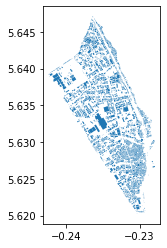


----------------------------
a42435 
----------------------------
{'area': 'acc', 'datetime': '2018-10-06 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 39162,
 'nodata': None,
 'transform': Affine(0.032029411960186015, 0.0, 804676.2688712641,
       0.0, -0.03202926727370731, 621829.9693785439),
 'width': 57540}

----------------------------
a42435-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-10-06 00:00:00Z',
 'label:description': 'Geojson building labels for scene a42435',
 'label:overviews': [{'counts': [{'count': 6647, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


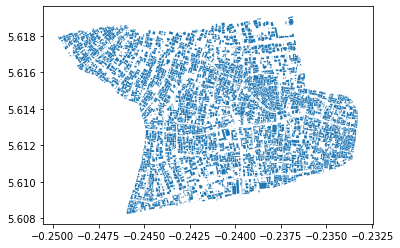


----------------------------
ca041a 
----------------------------
{'area': 'acc', 'datetime': '2018-11-12 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 77778,
 'nodata': None,
 'transform': Affine(0.035820209694930036, 0.0, 807207.717115721,
       0.0, -0.035820613560994544, 620903.4357975163),
 'width': 65882}

----------------------------
ca041a-labels 
----------------------------
{'area': 'acc',
 'datetime': '2018-11-12 00:00:00Z',
 'label:description': 'Geojson building labels for scene ca041a',
 'label:overviews': [{'counts': [{'count': 10194, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


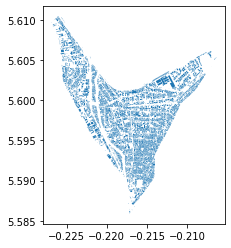


----------------------------
d41d81 
----------------------------
{'area': 'acc', 'datetime': '2019-07-07 00:00:00Z', 'license': 'CC BY 4.0'}
raster metadata:
{'count': 4,
 'crs': CRS.from_epsg(32630),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 42719,
 'nodata': None,
 'transform': Affine(0.05179965064903244, 0.0, 809267.1099320438,
       0.0, -0.05180039261972288, 618981.5459276063),
 'width': 40868}

----------------------------
d41d81-labels 
----------------------------
{'area': 'acc',
 'datetime': '2019-07-07 00:00:00Z',
 'label:description': 'Geojson building labels for scene d41d81',
 'label:overviews': [{'counts': [{'count': 9436, 'name': 'yes'}],
                      'property_key': ['building']}],
 'label:properties': ['building'],
 'label:type': 'vector',
 'license': 'ODbL-1.0'}


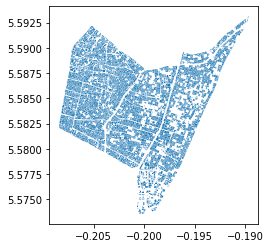


----------------------------


In [20]:
# for all items within acc col, either load and display label geojson with geopandas or raster metadata with rasterio

for i in cols['acc'].get_all_items():
    print(i.id, '\n----------------------------')
    pprint(i.properties)
    if 'label' in i.id:

        gdf = gpd.read_file(
            i.make_asset_hrefs_absolute().assets['labels'].href)
        gdf.plot()
        plt.show()
    else:
        print('raster metadata:')
        pprint(rasterio.open(
            i.make_asset_hrefs_absolute().assets['image'].href).meta)
    print('\n----------------------------')

In [21]:
# open one image item
SCENE_ID = 'ca041a'

one_item = cols['acc'].get_item(id=SCENE_ID)
one_item.to_dict()

{'type': 'Feature',
 'stac_version': '0.8.1',
 'id': 'ca041a',
 'properties': {'area': 'acc',
  'license': 'CC BY 4.0',
  'datetime': '2018-11-12T00:00:00Z'},
 'geometry': {'coordinates': [[[-0.2260939759101167, 5.607821019807083],
    [-0.22707525357332697, 5.609567361411101],
    [-0.2257626190986551, 5.610742610987594],
    [-0.2209214783972656, 5.60396659440964],
    [-0.2209297943096631, 5.603475955578037],
    [-0.21938590601191368, 5.601711342600872],
    [-0.21863322644066166, 5.601370284670147],
    [-0.2171984310079642, 5.60126443910544],
    [-0.2150344772406196, 5.602172946869177],
    [-0.21221192884842804, 5.603687126475405],
    [-0.2071666235973881, 5.60628622311988],
    [-0.20581415249279408, 5.604666197948947],
    [-0.2074253572000044, 5.603584221065274],
    [-0.2083544460457665, 5.6019965375946645],
    [-0.20906008314381597, 5.600996885039098],
    [-0.21070656970592522, 5.599526807751497],
    [-0.2114122068039735, 5.597897962116837],
    [-0.212416616071534, 5.

In [22]:
# load raster for this item
rst = rasterio.open(one_item.assets['image'].href)
rst.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65882,
 'height': 77778,
 'count': 4,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(0.035820209694930036, 0.0, 807207.717115721,
        0.0, -0.035820613560994544, 620903.4357975163)}

In [24]:
# check raster resolution
rst.res

(0.035820209694930036, 0.035820613560994544)

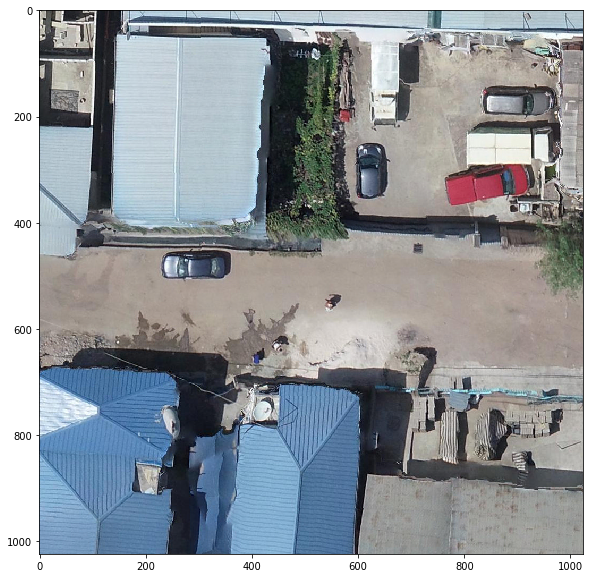

In [27]:
# make a windowed read of this raster and reshape into a displayable 4-d array (RGB+alpha channel)
# more on windowed reads with rasterio: https://rasterio.readthedocs.io/en/stable/topics/windowed-rw.html#windows

win_sz = 1024

window = Window(rst.meta['width']//2,rst.meta['height']//2,win_sz,win_sz) # 1024x1024 window starting at center of raster
win_arr = rst.read(window=window)
win_arr = np.moveaxis(win_arr,0,2)
plt.figure(figsize=(10,10))
plt.imshow(win_arr)

In [ ]:
DATA_PATH = "/home/zakirov/datasets/opencities/train_tier_1/"